# Partial differential equations solver (task N1)

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from numpy import sqrt, exp, sinh

## Equation statement

In [2]:
# interval
a, b = 2, 5
# boundary conditions
a1, b1, g1 = 0, 1, 0
a2, b2, g2 = 1, -2, 0

p = lambda t: 0.5 / (t - 1)
q = lambda t: np.zeros_like(t)
f = lambda t: 5 * sqrt(t - 1)

# exact solution
exact    = lambda x: -5*(x-1)/sqrt(x-1) + (x-1)**2.5 + 15.5

## ODE solution

In [3]:
# 4 order Runge-Kutta method
def solve(t, value, derivative):
    """solve equation for 
    y (a) = value
    y'(a) = derivative
    """
    
    from scipy.integrate import odeint
    
    # x = (y, y')

    def func(x, t):
        # y'' + p*y' + q*y = f; x0 = y, x1 = y'
        return [
            x[1],
            f(t) - p(t)*x[1] - q(t)*x[0]
        ]
    
    x0 = [value, derivative]
    return odeint(func, x0, t)

## Auxiliary 

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot(x = None, y = None, figsize = (20, 14), s = 27, lw = 2, ls = '-', edgecolor = 'black', restart = True, label = None, line = True, scatter = False, *args, **kwargs):
    """Nice simple wrapper around the default matplotlib plotter"""
    
    params = { 
    'font.size'           : 20, 
    'figure.figsize'      : figsize,
    'font.family'         : 'DejaVu Sans Mono',
    'axes.titlepad'       : 20
    }   

    plt.rcParams.update(params)

    # for quick plots
    if x is None:
        x = range(len(y))

    # use the same canvas
    if restart or not hasattr(plot, 'ax'):
        fig, ax = plt.subplots()
        plot.ax  = ax
        plot.fig = fig 
    
        ax.grid(color='#e5e5e5', linestyle='--', linewidth=1)
        ax.set_facecolor((0.995, 0.995, 1)) 
    
    
    ax  = plot.ax
    fig = plot.fig
    
    if scatter:
        ax.scatter(x, y, s=s, edgecolor = edgecolor, label = label, zorder = 100, *args, **kwargs) 
    if line:
        ax.plot(x, y, linestyle=ls, lw=lw, markersize=7, label = '_nolegend_' if scatter else label , zorder = 99, *args, **kwargs)
    
    
    return ax

# helper class
class Dim:
    def __init__(self, min, max, N):
        self.h   = float(max - min) / N
        self.min = float(min)
        self.max = float(max)
        self.N  = N + 1 # for convinience

    def __getitem__(self, n):
        return self.min + self.h * n

# Shooting

In [5]:
def residual(t, value, derivative, do_plot = False):
    residual.n += 1
    n = residual.n
    
    sol = solve(t, value, derivative)
    y   = sol[:, 0]
    y_x = sol[:, 1]
    
    if do_plot:
        ax = plot(t, y, restart = False, ls= '--', lw = 1, label = f"n = {residual.n}")
        
    return a2*y[-1] + b2*y_x[-1] - g2

In [6]:
def shooting(x, tol, do_plot = False):
    residual.n = 0
    
    t = np.linspace(x.min, x.max, N)
    derivative = 0

    from scipy import optimize
    val = sc.optimize.bisect(lambda x: residual(t, x, derivative, do_plot), 0, 23, xtol = tol)

    sol = solve(t, val, derivative)
    y   = sol[:, 0]

    return t, y

Maximum error: 8.98e-02


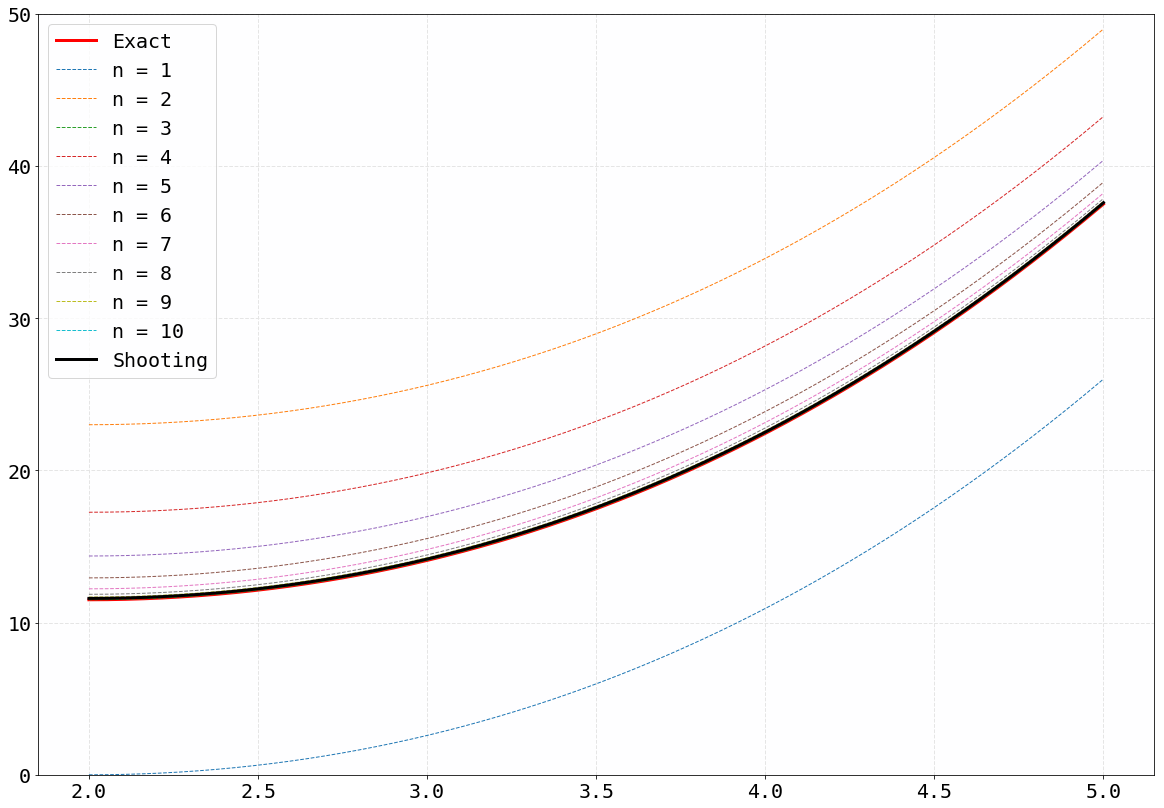

In [7]:
# exact solution
X = np.linspace(a, b, 1000)
ax = plot(X, exact(X), color='red', lw=3, label = 'Exact')

N = 1000
x = Dim(min = a, max = b, N = N)
t, y = shooting(x, 0.1, do_plot = True)

plot(t, y, restart = False, color='black', lw=3, label = 'Shooting')

ax.legend()
ax.set_ylim(0, 50)

err = abs(exact(t) - y).max()
print("Maximum error: {:.2e}".format(err))

# TDM

In [8]:
def TDM(x):
    A = np.zeros((x.N, x.N))
    B = np.zeros(x.N)

    # mesh
    X = np.linspace(a, b, x.N)
    P, Q, F = p(X), q(X), f(X)

    A[0, 0] = a1 * x.h - b1
    A[0, 1] = b1
    B[0]    = g1 * x.h

    for n in range(1, x.N - 1):
        A[n, n+1] =  1 + P[n] *  x.h/2
        A[n, n]   = -2 + Q[n] * (x.h**2)
        A[n, n-1] =  1 - P[n] *  x.h/2
        B[n]      =  0 + F[n] * (x.h**2)

    A[x.N - 1, x.N - 2] = -b2
    A[x.N - 1, x.N - 1] =  b2 + a2 * x.h
    B[x.N - 1]          =  g2 * x.h
    
    return X, np.linalg.solve(A, B)

def TDM2(x):
    A = np.zeros((x.N, x.N))
    B = np.zeros(x.N)

    # mesh
    X = np.linspace(a, b, x.N)
    P, Q, F = p(X), q(X), f(X)

    A[0, 0] = a1 * 2 * x.h - 3 * b1
    A[0, 1] = 4 * b1
    A[0, 2] = -b1
    B[0]    = g1 * 2 * x.h

    for n in range(1, x.N - 1):
        A[n, n+1] =  1 + P[n] *  x.h/2
        A[n, n]   = -2 + Q[n] * (x.h**2)
        A[n, n-1] =  1 - P[n] *  x.h/2
        B[n]      =  0 + F[n] * (x.h**2)

    A[x.N - 1, x.N - 3] =    b2
    A[x.N - 1, x.N - 2] = -4*b2
    A[x.N - 1, x.N - 1] =  3*b2 + a2 * 2 * x.h
    B[x.N - 1]          =    g2 * 2 * x.h
    
    return X, np.linalg.solve(A, B)

Maximum error: 1.02e+00


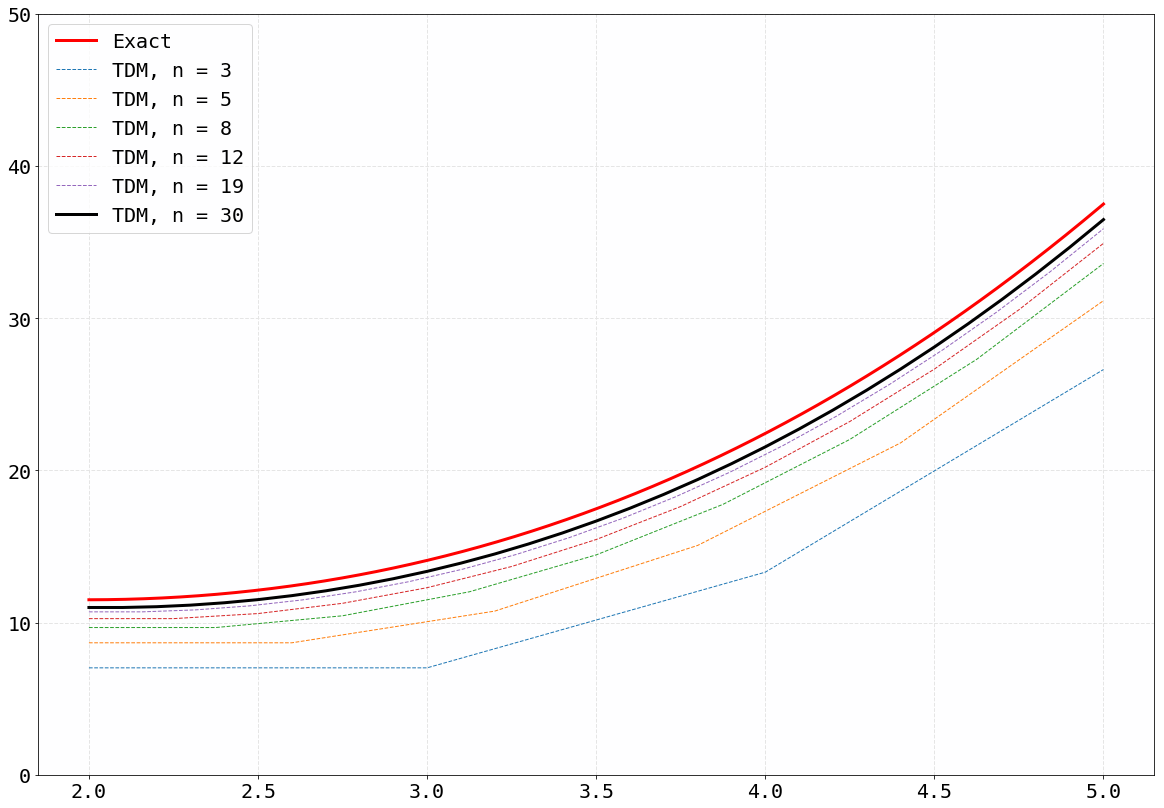

In [9]:
# exact solution
ax = plot(X, exact(X), color='red', lw=3, label = 'Exact')

N = 30
for n in np.logspace(np.log(3), np.log(N), 6, base = np.e).round().astype(int):
    # solution:
    x = Dim(min = a, max = b, N = n)
    X, Y = TDM(x)
    if n == N:
        plot(X, Y, lw=3, ls = '-', label = f'TDM, n = {n}', restart = False, color = 'black')
    else:
        plot(X, Y, lw=1, ls = '--', label = f'TDM, n = {n}', restart = False)
        
ax.legend()
ax.set_ylim(0, 50)

err = abs(exact(X) - Y).max()
print("Maximum error: {:.2e}".format(err))

# Methods comparison

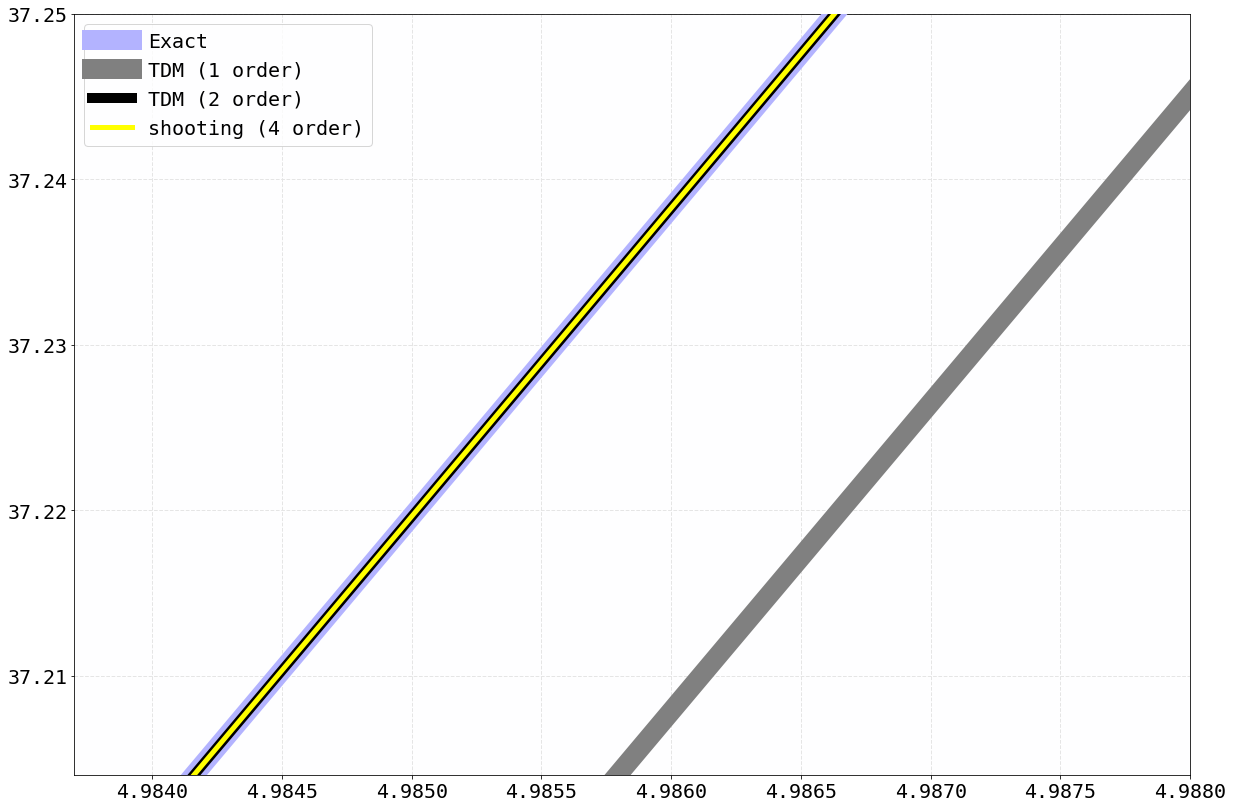

In [10]:
# exact solution
X = np.linspace(a, b, 1000)
ax = plot(X, exact(X), color=(0.7,0.7,1), lw=20, label = 'Exact')

N = 1000
x = Dim(min = a, max = b, N = N)

X, Y = TDM(x)
plot(X, Y, lw=20, ls = '-', label = f'TDM (1 order)',     restart = False, color = 'gray')
X, Y = TDM2(x)
plot(X, Y, lw=10, ls = '-', label = f'TDM (2 order)',     restart = False, color = 'black')
X, Y = shooting(x, 1e-10)
plot(X, Y, lw=5, ls = '-', label = f'shooting (4 order)',  restart = False, color = 'yellow')
ax.legend()

# Zooming
plt.ylim(37.204, 37.25)
plt.xlim(4.9837, 4.988);

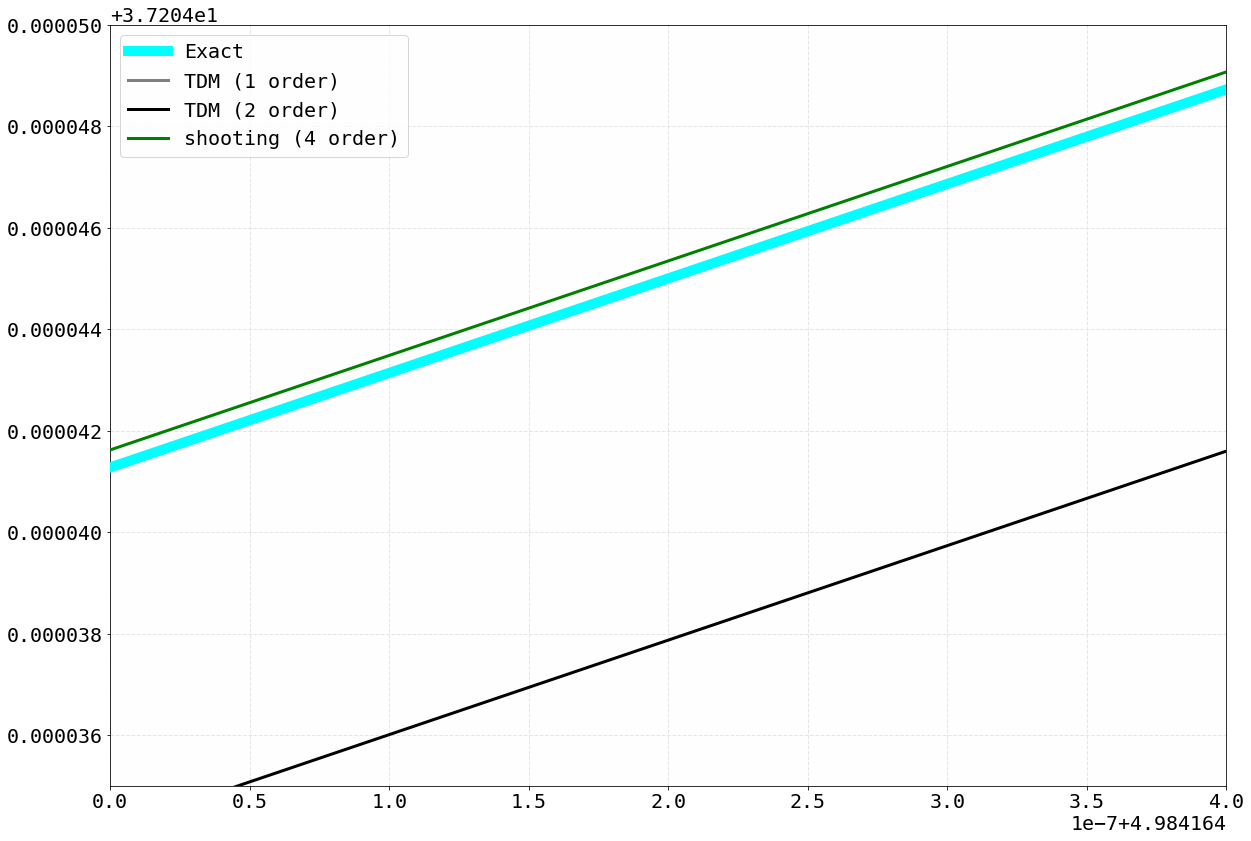

In [11]:
# exact solution
X = np.linspace(a, b, 1000)
ax = plot(X, exact(X), color='cyan', lw=10, label = 'Exact')

N = 1000
x = Dim(min = a, max = b, N = N)

X, Y = TDM(x)
plot(X, Y, lw=3, ls = '-', label = f'TDM (1 order)',     restart = False, color = 'gray')
X, Y = TDM2(x)
plot(X, Y, lw=3, ls = '-', label = f'TDM (2 order)',     restart = False, color = 'black')
X, Y = shooting(x, 1e-10)
plot(X, Y, lw=3, ls = '-', label = f'shooting (4 order)', restart = False, color = 'green')
ax.legend()

# Zooming
plt.ylim(37.204035, 37.204050)
plt.xlim(4.984164, 4.9841644);